In [2]:
# Import libraries and functions
import random
import itertools
import math
import torch
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# General Setup
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# load and modify the data
pokemon = pd.read_csv('../data/scraped.csv')

# Define columns
to_drop = []
categorical = ["type_2",'status']
weakness = ['damage_from_normal', 'damage_from_fire', 'damage_from_water', 'damage_from_electric',
            'damage_from_grass', 'damage_from_ice', 'damage_from_fighting', 'damage_from_poison',
            'damage_from_ground', 'damage_from_flying', 'damage_from_psychic', 'damage_from_bug','damage_from_rock',
            'damage_from_ghost', 'damage_from_dragon', 'damage_from_dark','damage_from_steel', 'damage_from_fairy']

# Drop unwanted variables
pokemon = pokemon.drop(columns=to_drop)

# Define class and features
y = pokemon['type_1']; # Class
X = pokemon.drop(['type_1'],axis=1) # Feature

# Store the label names
y_label = pokemon['type_1'] # uncoded features

# Encode categorical variables
y = pd.get_dummies(y)
X = pd.get_dummies(X,columns=categorical)

# Scale numerical variables
scaler = MinMaxScaler()
ending = sum(X.dtypes == ["float64"]*X.shape[1])
X.iloc[:,:ending] = scaler.fit_transform(X.iloc[:,:ending])

# Convert training and testing data into PyTorch tensor
y = torch.tensor(y.values).float()
X = torch.tensor(X.values).float()

# Set up number classes and features
n_class = 18
n_feature = X.shape[1]

In [4]:
# Define model
class NN(nn.Module):
    
    # Set up model
    def __init__(self, node_list,drop):
        super(NN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(1, len(node_list)):
            self.layers.append(nn.Linear(node_list[i-1], node_list[i]))
        
        self.activation = nn.ReLU() # activation function
        self.dropout = nn.Dropout(p=drop) # drop rate
    
    # Set up forward function
    def forward(self, x):
        out = x
        for i in range(len(self.layers)-1):
            out = self.layers[i](out)
            out = self.activation(out)
        out = self.layers[len(self.layers)-1](out)
        return out

In [5]:
# Prediction function
def predict(model, X, y):
    
    # Set up loader
    test_dataset = TensorDataset(X,y)
    loader = DataLoader(test_dataset, batch_size = 9999, shuffle = False)
    
    # Set model to evaluation
    model.eval()
    
    # Evaluate model
    num_correct = 0
    num_samples = 0
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)
            model_result = model(x)
            _, prediction = model_result.max(1)
            _, actual = y.max(1)
            num_correct += (prediction == actual).sum()
            num_samples += prediction.size(0)
    
    # Set model to training
    model.train()
    
    # Compute accuracy
    accuracy = num_correct/num_samples
    
    return prediction.cpu().numpy(), actual.cpu().numpy(), accuracy.cpu().item()

In [6]:
# Training function
def train_model(num_epochs, batch_size, node_list, drop, X, y):

    # Create the model
    model = NN([n_feature]+node_list+[n_class], drop).to(device)

    # Set up loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    # Set up data loader
    train_dataset = TensorDataset(X,y)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    
    # Initialize loss
    loss = []
    
    # Train model
    for epoch in range(num_epochs):
        for batch_idx, (data, targets) in enumerate(train_loader):
            # Get data to cuda if possible
            data = data.to(device = device)
            targets = targets.to(device = device)

            # Reshape data
            data = data.reshape(data.shape[0], -1)
            
            # Forward propagation
            model_result = model(data)
            current_loss = criterion(model_result, targets)
            
            # Zero previous gradients
            optimizer.zero_grad()
            
            # back-propagation
            current_loss.backward()
            
            # optimize
            optimizer.step()
        
        # Record loss of the current epoch
        loss.append(float(current_loss.item()))
            
    return model, loss

In [7]:
def model_examination(num_epochs, batch_size, node_list, drop, X_train, y_train, X_test, y_test):
    # Train model
    model, loss = train_model(num_epochs, batch_size, node_list, drop, X_train, y_train)
    # Estimate model accuracy
    pred, actual, accuracy = predict(model, X_test, y_test)
    
    return model, loss, pred, actual, accuracy

In [8]:
def model_examination_repeated_cv(num_epochs, batch_size, node_list, drop, X, y, n_split, repeat, y_label):
    
    # Set up and initialize
    skf = StratifiedKFold(n_splits=n_split,random_state=441, shuffle=True)
    acc = []
    
    # Perform k-fold cv n times, record result for every model trained
    for ii in tqdm(range(repeat),leave=False):
        acc_temp = []
        for idx, (train_index, test_index) in enumerate(skf.split(X,y_label)):
            # Set up test and training variables
            X_test = X[test_index]; y_test = y[test_index]; 
            X_train = X[train_index]; y_train = y[train_index]
            # train the model and evaluate the accuracy
            model, _ = train_model(num_epochs,batch_size,node_list,drop,X_train,y_train)
            _,_, accuracy = predict(model, X_test, y_test)
            accuracy = accuracy
            acc_temp.append(accuracy)
        acc.append(acc_temp)

    return acc

In [9]:
def merge_list(lst):
    lst_final = list(itertools.chain.from_iterable(lst))
    return lst_final

# Check if function works properly

NN(
  (layers): ModuleList(
    (0): Linear(in_features=74, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=18, bias=True)
  )
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
1.0
[12 17 17 15 14 17 17 16 11 17 17 17  5  2  4 16 12 17 11 16 13 17  3 10
  2 12  9  9 13  0  5  6 17  8 17 17  3  6  3 10 17  0  5  0 17 15  0 10
  9 12  5  9  8 16  0 14  2  0  0  5  4  8  8  3 11 17 17  2 14  3  2  9
  3 17 16 17  9  3  9  5 15 12  8 14 12  0  8 16  8  9  3  1  0 12 14  9
 17 12 17 11 13 10 17  3 13 12 12  0  6 12  3 17 12  6  6 11 16  8 17  9
  5 17  0 12  8  0  9 14 12  9 16 14  1  8  8  0  2  0 15  2  0 15 16 17
 10 15 17  0 12  9  2 17  4  1  0 15  3  1  0  2  1 13  0 17  6  0 14 13
  8 17 13 14  9  0 17  1  3 16 14 17  9  8  6  0 10 14 14 14 17  9  1 10
 13 12  6 10  0 17 17 12  6 10 11 12 17 16 13  9 14  9 12]
[12 17 17 15 14 17 17 16 11 17 17 17  5  2  4 16 12 17 11 16 13 17  3 10
  2 12  9  9 13  0  5  6 17  8 17 17  3  6  3 10 17  0  5 

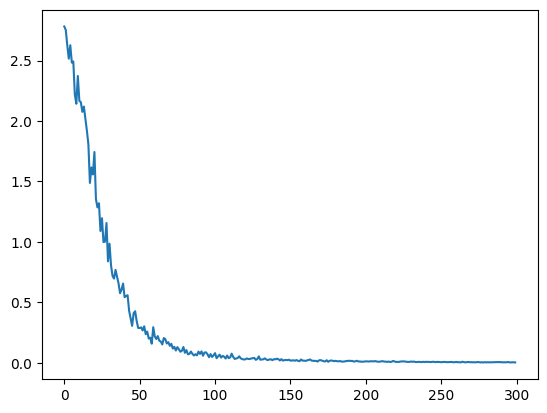

In [11]:
num_epochs,batch_size,drop = 300,200,0.2
node_list = [300]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=random.seed(time.time()))
model, loss, pred, actual, accuracy = model_examination(num_epochs, batch_size, node_list, drop,
                                                        X_train, y_train, X_test, y_test)
print(model)
print(accuracy)
plt.plot(loss)

_,_,pred,actual,accuracy = model_examination(num_epochs,batch_size,node_list,drop,X_train,y_train,X_test,y_test)
print(pred)
print(actual)
# acc_test = model_examination_repeated_cv(num_epochs,batch_size,node_list,drop,X,y,5,5,y_label)
# print(acc_test)
# acc_test_merged = merge_list(acc_test)
# print(sum(acc_test_merged)/len(acc_test_merged))

# Examine how number of layers and nodes affect the performance

In [ ]:
# Set up initial parameters
max_hidden_layer = 5
node_max_multiplier = 9
num_epochs,batch_size,drop = 400,200,0.2

acc_1 = []

# Fix number of hidden layer
for i in tqdm(range(max_hidden_layer)):
    # Number of nodes per layer
    for j in tqdm(range(node_max_multiplier),leave=False):
        node_list = [100+25*j]*(i+1)
        acc_list = model_examination_repeated_cv(num_epochs,batch_size,node_list,drop,X,y,5,5,y_label)
        # Record result for each set up
        acc_1.append(acc_list)

[[[0.9810426831245422, 1.0, 0.9763033390045166, 0.9905213713645935, 0.9952381253242493], [0.9810426831245422, 1.0, 0.9763033390045166, 0.9905213713645935, 1.0], [0.9810426831245422, 0.9952607154846191, 0.9810426831245422, 0.9857820272445679, 0.9952381253242493], [0.9810426831245422, 1.0, 0.9763033390045166, 0.9905213713645935, 0.9952381253242493], [0.9810426831245422, 0.9952607154846191, 0.9763033390045166, 0.9905213713645935, 0.9952381253242493]], [[0.9810426831245422, 1.0, 0.9763033390045166, 0.9857820272445679, 0.9952381253242493], [0.9810426831245422, 0.9952607154846191, 0.9810426831245422, 0.9905213713645935, 0.9952381253242493], [0.9810426831245422, 0.9952607154846191, 0.9810426831245422, 0.9905213713645935, 0.9952381253242493], [0.9810426831245422, 0.9952607154846191, 0.9763033390045166, 0.9905213713645935, 0.9952381253242493], [0.9810426831245422, 1.0, 0.9763033390045166, 0.9905213713645935, 0.9952381253242493]], [[0.9810426831245422, 1.0, 0.9763033390045166, 0.9857820272445679

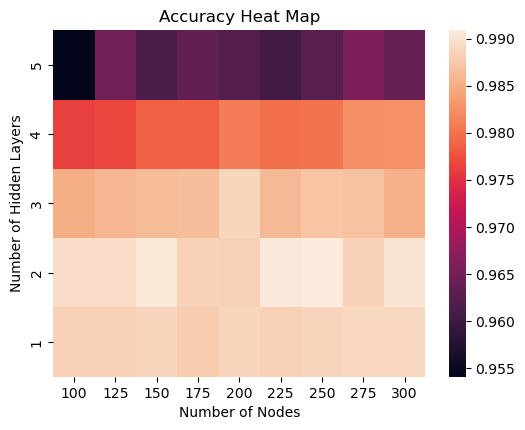

<Figure size 640x480 with 0 Axes>

In [147]:
# Create heat map
acc_1_temp = acc_1 # Save the result into a temporary variable that will be modified
print(acc_1_temp)
# transform acc_1_temp into heat map list
hmlst1 = [[],[],[],[],[]]
counter = 0
for i in range(max_hidden_layer):
    for j in range(node_max_multiplier):
        merged_list = merge_list(acc_1_temp[counter])
        hmlst1[i].append(sum(merged_list)/len(merged_list))
        counter += 1

# Create Heat map
fix, ax = plt.subplots(figsize=(6,4.5))
hmlst1 = hmlst1[::-1]
hm1 = sns.heatmap(hmlst1)
hm1.set_xlabel('Number of Nodes')
hm1.set_ylabel('Number of Hidden Layers')
hm1.set_xticklabels(list(range(100,325,25)))
hm1.set_yticklabels(list(range(5,0,-1)))
plt.title('Accuracy Heat Map')
plt.show()
plt.savefig('Stat 441 NN Accuracy Heat map')

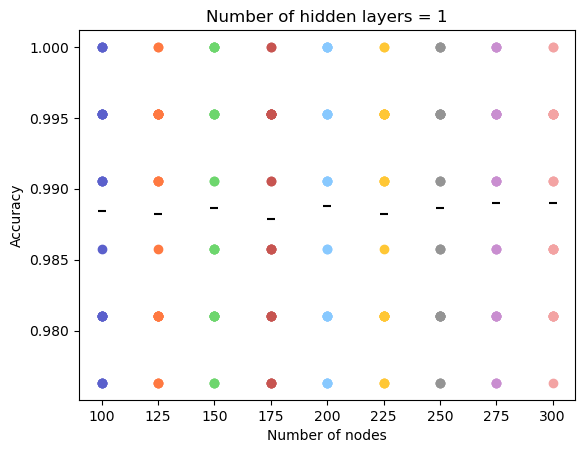

<Figure size 640x480 with 0 Axes>

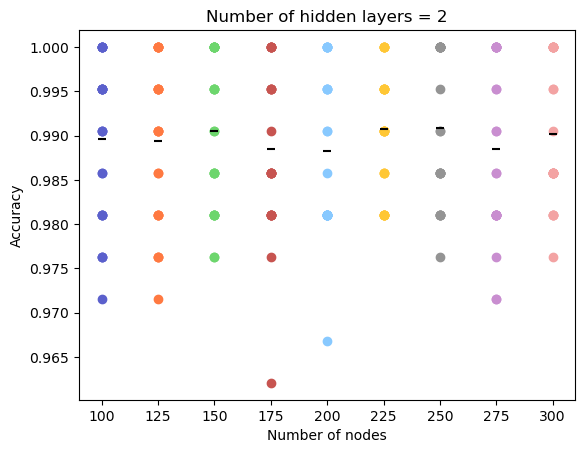

<Figure size 640x480 with 0 Axes>

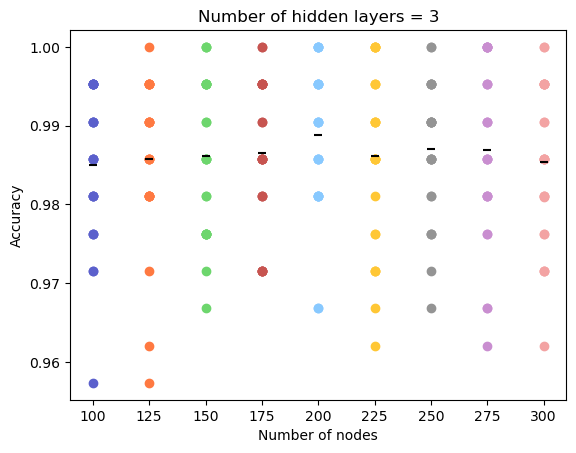

<Figure size 640x480 with 0 Axes>

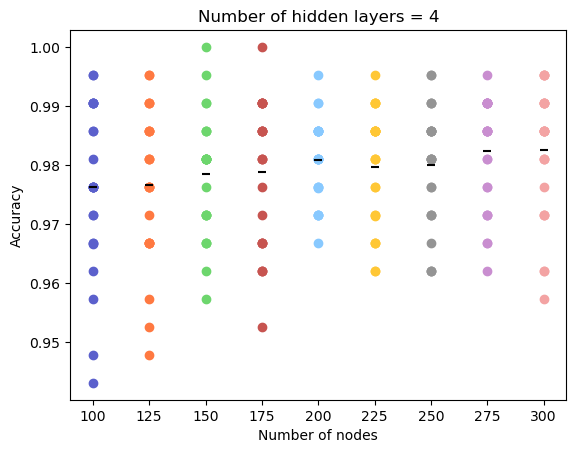

<Figure size 640x480 with 0 Axes>

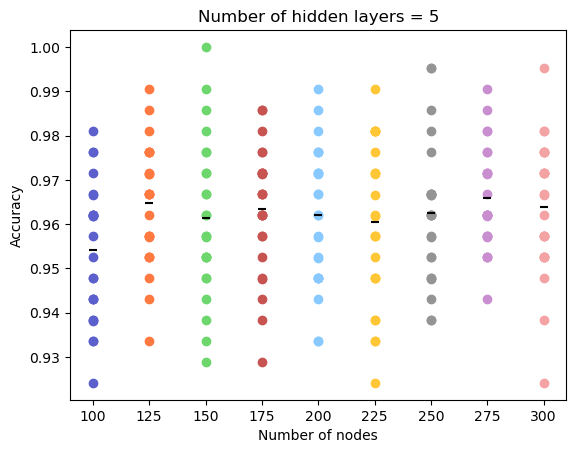

<Figure size 640x480 with 0 Axes>

In [148]:
# Create scatterplot for each layer
scatter = [[],[],[],[],[]]
colors = ['#5b60cc', '#ff7941', '#6dd66d', '#c75450', '#88c9ff', '#ffc735', '#949494', '#c98ed0', '#f3a3a3', '#53c0a6', '#d85c3e']
counter = 0
# Extract the data
for i in range(max_hidden_layer):
    for j in range(node_max_multiplier):
        scatter[i].append(merge_list(acc_1_temp[counter]))
        counter += 1
# Plot for different layers
for ii in range(5):
    fig, ax = plt.subplots()
    for i, lst in enumerate(scatter[ii]):
        x = [i*25+100]*len(lst)
        color_index = i%len(colors)
        ax.scatter(x,lst,color=colors[color_index])
        ax.scatter(i*25+100,sum(lst)/len(lst),marker="_",color='black')
    ax.set_xlabel('Number of nodes')
    ax.set_ylabel('Accuracy')
    ax.set_title('Number of hidden layers = '+str(ii+1))
    plt.show()
    plt.savefig('Stat 441 NN Optimization ' + str(ii+1))

In [ ]:
# Optimize drop rate, batch size and learning rate using 2 layers with 250 nodes per layer
epoch_lst = [300,350,400,450,500]
batch_lst = [100,125,150,175,200,225,250]
drop_lst = [0.2,0.225,0.25,0.275,0.3]

# Optimal node_list
node_list = [250,250]
acc_2 = []
for i in tqdm(range(len(epoch_lst))):
    acc_batch = []
    for j in tqdm(range(len(batch_lst)),leave=False):
        acc_drop = []
        for k in tqdm(range(len(drop_lst)),leave=False):
            drop = drop_lst[k]/100;
            batch_size = batch_lst[j]
            num_epochs = epoch_lst[i]
            acc_list = merge_list(model_examination_repeated_cv(num_epochs,batch_size,node_list,drop,X,y,5,5,y_label))
            acc_drop.append(sum(acc_list)/len(acc_list))
        acc_batch.append(acc_drop)
    acc_2.append(acc_batch)

In [75]:
acc_2_temp = acc_2
print(acc_2_temp)

[[[0.9899517250061035, 0.98900386095047, 0.9903317785263062, 0.9905204463005066, 0.9908995962142945], [0.9901413011550904, 0.9920379376411438, 0.9910891675949096, 0.9901412987709045, 0.9910900735855103], [0.9907100224494934, 0.9910882663726807, 0.9905186438560486, 0.9907100200653076, 0.9897621560096741], [0.9903317761421203, 0.9899499249458313, 0.9897630548477173, 0.9907082176208496, 0.9922266101837158], [0.9912796449661255, 0.988810682296753, 0.9903308749198914, 0.9901412987709045, 0.9901412987709045], [0.9907100200653076, 0.9895707774162292, 0.9912778401374817, 0.9897612524032593, 0.9905177426338195], [0.9899490213394165, 0.9891934370994568, 0.9908995938301086, 0.9890029549598693, 0.9888124823570251]], [[0.99317538022995, 0.9914683151245117, 0.9918474626541137, 0.9916587924957275, 0.9910900688171387], [0.9920379376411438, 0.9914683151245117, 0.9916569876670838, 0.9908977913856506, 0.9918474626541137], [0.9903317737579346, 0.9908986949920654, 0.9895725798606873, 0.9901413011550904, 0.

In [107]:
# check how epcoh affects the accuracy
epoch_result = []
for i in range(len(epoch_lst)):
    lst_temp = []
    for j in range(len(batch_lst)):
        for k in range(len(drop_lst)):
            lst_temp.append(acc_2_temp[i][j][k])
    epoch_result.append(sum(lst_temp)/len(lst_temp))

batch_result = []
for j in range(len(batch_lst)):
    lst_temp = []
    for i in range(len(epoch_lst)):
        for k in range(len(drop_lst)):
            lst_temp.append(acc_2_temp[i][j][k])
    batch_result.append(sum(lst_temp)/len(lst_temp))

drop_result = []
for k in range(len(drop_lst)):
    lst_temp = []
    for i in range(len(epoch_lst)):
        for j in range(len(batch_lst)):
            lst_temp.append(acc_2_temp[i][j][k])
    drop_result.append(sum(lst_temp)/len(lst_temp))

print(epoch_result)
print(batch_result)
print(drop_result)

max_index = [0,0,0]
current_max = 0
for i in range(len(epoch_lst)):
    for j in range(len(batch_lst)):
        for k in range(len(drop_lst)):
            val_temp = acc_2_temp[i][j][k]
            if val_temp > current_max:
                max_index = [i,j,k]
                current_max = val_temp
print(max_index)
print(acc_2_temp[max_index[0]][max_index[1]][max_index[2]])

min_index = [0,0,0]
current_min = 1
for i in range(len(epoch_lst)):
    for j in range(len(batch_lst)):
        for k in range(len(drop_lst)):
            val_temp = acc_2_temp[i][j][k]
            if val_temp < current_min:
                min_index = [i,j,k]
                current_min = val_temp
print(min_index)
print(acc_2_temp[min_index[0]][min_index[1]][min_index[2]])

[0.9903249942915782, 0.9908617572103229, 0.9909322734560285, 0.9910296653338843, 0.9910948171615601]
[0.9913776809692384, 0.9910287937164308, 0.991028649044037, 0.9911497961044311, 0.9905735278129579, 0.9904367832183838, 0.9903456795692446]
[0.9909377924374171, 0.9906773176874434, 0.9908237655503407, 0.9908886586597987, 0.9909159731183733]
[1, 0, 0]
0.99317538022995
[0, 4, 1]
0.988810682296753


The optimal result reached an accuracy of 0.993175 with epoch = 350, batch = 125, drop rate = 0.2 and the worst result has an accuracy of 0.9888 where epoch = 300, batch = 250, drop = 0.225. The difference between the two prediction accuracy is very small and its likely caused by the stochasticity during fitting. This implies optimization over epoch, batch, drop rate is rather unnecessary as optimzing them do not improve accuracy drastically. A potential reason is that type_2 and damage_from variable plays very important role determining the types of pokemons. Therefore, there is a clear path for the trainer to optimize the weights and biases and lead to similar results everytime. In other wrod, the examined epoch, batch, drop could not affect the training process effectively, not even in the negative manner.

In [ ]:
# Do a random nested CV to examine the NN performence,
skf = StratifiedKFold(n_splits = 5, random_state = 441, shuffle = True)
acc = []
pred_lst = []
actual_lst = []
for idx, (train_index, test_index) in enumerate(skf.split(X,y_label)):
    print('Split: '+ str(idx+1))
    # Split the data
    X_test = X[test_index]; y_test = y[test_index]; y_label_test = y_label[test_index];
    X_train = X[train_index]; y_train = y[train_index]; y_label_train = y_label[train_index];
    # Set up the parameters
    epoch_final = 300
    batch_final = 100
    node_final = [250,250]
    drop_final = 0.2
    # Examine the best parameter optimized before
    acc_inner_cv = merge_list(model_examination_repeated_cv(epoch_final,batch_final,node_final,drop_final,
                                                            X_train,y_train,5,4,y_label_train))
    acc_current = sum(acc_inner_cv)/len(acc_inner_cv)
    # Randomly generate 19 hyperparameters and see if they beat the optimized hyperparameters, if so record them
    for i in tqdm(range(19),leave=False):
        num_epochs = random.randint(275,325)
        batch_size = random.randint(75,125)
        node_list = [random.randint(225,275),random.randint(225,275)]
        drop = random.randint(17,23)/100
        acc_inner_cv = merge_list(model_examination_repeated_cv(num_epochs,batch_size,node_list,drop,
                                                                X_train,y_train,5,4,y_label_train))
        acc_temp = sum(acc_inner_cv)/len(acc_inner_cv)
        if acc_temp > acc_current:
            epoch_final = num_epochs
            batch_final = batch_size
            node_final = node_list
            drop_final = drop
            acc_current = acc_temp
    
    # With the best hyper parameters found, we examine its performance
    _,_,pred,actual, accuracy_final = model_examination(epoch_final, batch_final, node_final, drop, X_train, y_train, X_test, y_test)
    acc.append(accuracy_final)
    pred_lst.append(pred)
    actual_lst.append(actual)

In [112]:
# Store the variables
acc_temp = acc
pred_temp = pred_lst
actual_temp = actual_lst
print(acc_temp)
print(sum(acc_temp)/len(acc_temp))

[0.9857820272445679, 1.0, 0.9810426831245422, 0.9810426831245422, 1.0]
0.9895734786987305


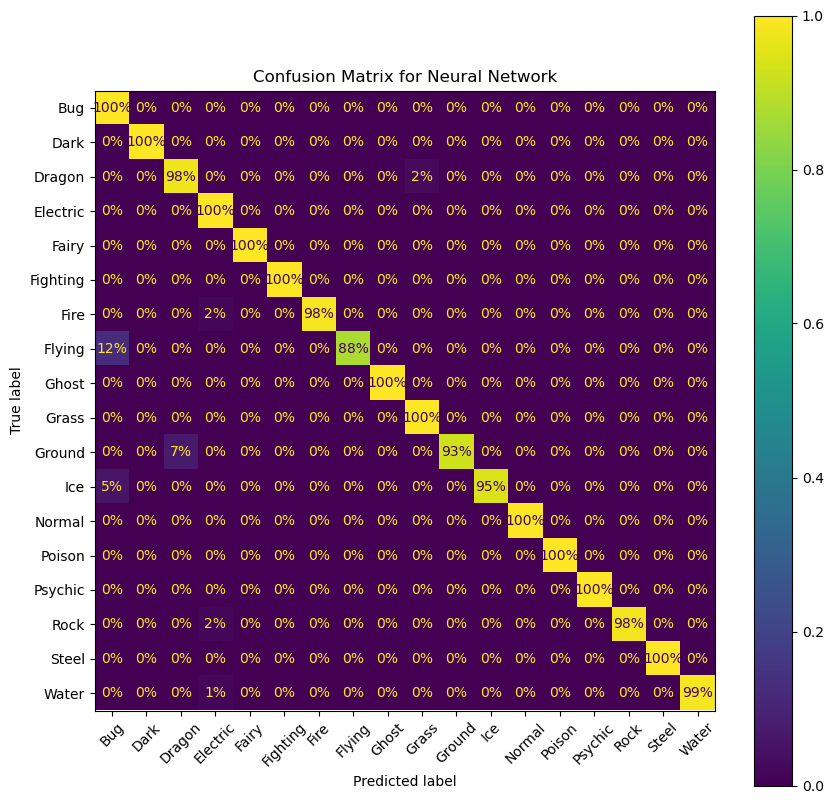

<Figure size 640x480 with 0 Axes>

In [149]:
# Compute confusion matrix
# Set up label names
labels = y_label.unique().tolist()
labels.sort()

# Compute final prediction and final actual
pred_final = merge_list(pred_temp)
actual_final = merge_list(actual_temp)

# Create confusion matrix and normalize
cm = confusion_matrix(actual_final, pred_final, normalize='true')

# Set up plot
fix, ax = plt.subplots(figsize=(10,10))
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_title('Confusion Matrix for Neural Network')
# display
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot(xticks_rotation=45, values_format='.0%',ax=ax)
plt.show()
plt.savefig('Stat 441 NN CM')